In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve, least_squares
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [11]:
def getEquilBidsTullock(v, alpha, guess=None):
    """
    Finds equilibrium bids in an n-player Tullock contest.

    u_i(b) = x_i(b) * v_i – b_i,       x_i(b) = b_i**alpha / sum_j b_j**alpha

    Parameters
    ----------
    v : array_like
        Positive valuations (length n).
    alpha : float
        Contest exponent (alpha > 0).
    guess : array_like, optional
        Starting point for the numerical solver.  If omitted, a scaled
        copy of `v` is used.

    Returns
    -------
    numpy.ndarray
        Equilibrium bid vector b* (length n).
    """
    v = np.asarray(v, dtype=float)
    n = v.size

    # --- symbolic set-up ----------------------------------------------------
    b_syms = sp.symbols(f"b0:{n}", positive=True)           # (b_0, …, b_{n-1})
    S = sum(b**alpha for b in b_syms)                      # ∑ b_j^α

    focs = [
        v[i] * alpha * b_syms[i] ** (alpha - 1) * (S - b_syms[i] ** alpha) / S ** 2 - 1
        for i in range(n)
    ]

    # --- numerical solve ----------------------------------------------------
    if guess is None:
        # light scaling keeps the initial point strictly positive
        guess = [vi / max(v) for vi in v]

    sol = sp.nsolve(focs, b_syms, guess, tol=1e-14, maxsteps=100)
    return np.array(sol, dtype=float)

def getAllosTullock(bids, a):
    denom = sum([b**a for b in bids])
    return np.array(bids**a) / denom

In [28]:
v      = np.array([1.0, 1.2])   # valuations
alpha  = 5/3.
b_star = solve_tullock_equilibrium(v, alpha)

b_star

array([[0.32845682],
       [0.39414818]])

In [86]:
alphas = [1, 4/3, 5/3]
c2s_plot = []
bids, allos, utils = [], [], []
for a in alphas:
    if a == 1:
        c2s = np.arange(1.01, 3.4, 0.01)
    else:
        ub = (a-1)**(-1/a)
        c2s = np.arange(1.01, ub, 0.01)
    c2s_plot.append(c2s)
    
    temp1, temp2, temp3 = [], [], []
    for c2 in c2s:
        v = np.array([1, c2])
        b_star = getEquilBidsTullock(v, alpha=a)
        x_star = getAllosTullock(b_star, a=a)
        u_star = np.array([v[i]*x_star[i] - b_star[i] for i in [0,1]])
        temp1.append(b_star)
        temp2.append(x_star)
        temp3.append(u_star)
    bids.append(np.array(temp1))
    allos.append(np.array(temp2))
    utils.append(np.array(temp3))

In [87]:
bids[0].shape, allos[0].shape, c2s_plot[0].shape, utils[0].shape

((239, 2, 1), (239, 2, 1), (239,), (239, 2, 1))

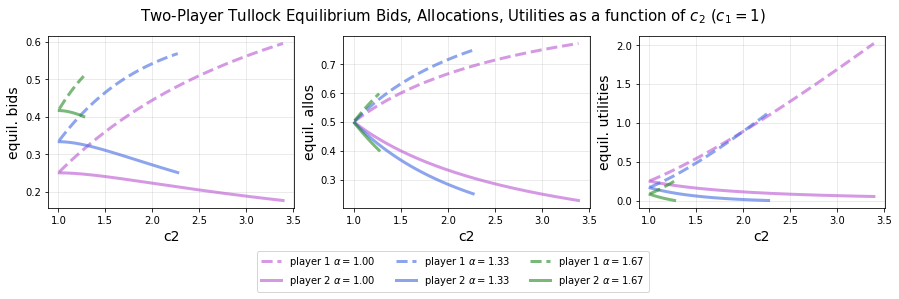

In [109]:
f, axarr = plt.subplots(ncols=3, figsize=(15,4))

colors = ['mediumorchid', 'royalblue', 'forestgreen']
for i, alpha in enumerate(alphas):
    axarr[0].plot(c2s_plot[i], bids[i][:,1,0], linewidth=3, alpha=0.6, linestyle='--',
                  label=r'player 1 $\alpha={:0.2f}$'.format(alpha), color=colors[i])
    axarr[0].plot(c2s_plot[i], bids[i][:,0,0], linewidth=3, alpha=0.6, linestyle='-',
                  label=r'player 2 $\alpha={:0.2f}$'.format(alpha), color=colors[i])
    
    axarr[1].plot(c2s_plot[i], allos[i][:,1,0], linewidth=3, alpha=0.6, linestyle='--',
                  label=r'p1 allos, $\alpha={:0.2f}$'.format(alpha), color=colors[i])
    axarr[1].plot(c2s_plot[i], allos[i][:,0,0], linewidth=3, alpha=0.6, linestyle='-',
                  label=r'p2 allos, $\alpha={:0.2f}$'.format(alpha), color=colors[i])
    
    axarr[2].plot(c2s_plot[i], utils[i][:,1,0], linewidth=3, alpha=0.6, linestyle='--',
                  label=r'p1 allos, $\alpha={:0.2f}$'.format(alpha), color=colors[i])
    axarr[2].plot(c2s_plot[i], utils[i][:,0,0], linewidth=3, alpha=0.6, linestyle='-',
                  label=r'p2 allos, $\alpha={:0.2f}$'.format(alpha), color=colors[i])
    
    
for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel('c2', size=14)

axarr[0].set_ylabel('equil. bids', size=14)
axarr[1].set_ylabel('equil. allos', size=14)
axarr[2].set_ylabel('equil. utilities', size=14)
f.suptitle(r'Two-Player Tullock Equilibrium Bids, Allocations, Utilities as a function of $c_2$ ($c_1=1$)', size=15)

handles, labels = axarr[0].get_legend_handles_labels()
f.legend(handles, labels,
         loc='upper center',
         bbox_to_anchor=(0.5, 0.15),   # tweak “-0.18” if you need more/less space
         ncol=3)

# make room at the bottom for the legend
f.subplots_adjust(bottom=0.28)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')

plt.show()

## tullock with alpha=1

In [59]:
alpha = 5/3
(alpha-1)**(-1/alpha)

1.2754245006257907

In [64]:
v = np.array([1.0, 1.28])
b_star = getEquilBidsTullock(v, alpha)
b_star, getAllosTullock(b_star, alpha)

(array([[0.3995194 ],
        [0.51138483]]),
 array([[0.39856845],
        [0.60143155]]))

In [158]:
alpha = 1
c2s   = np.arange(1, 9, 0.1) 
ns    = [1, 2, 4, 8]

In [160]:
getEquilBidsTullock([10,1,1,1], alpha=alpha, guess=[2,1,1,1])

array([[0.8448],
       [0.0384],
       [0.0384],
       [0.0384]])

In [168]:
bids, allos, scs = [], [], []
for n in ns:
    temp1, temp2, temp3 = [],[],[]
    for c2 in c2s:
        print(n, c2, end='\r')
        v = [10-1]
        c = [1]
        v.extend([10-c2]*n)
        c.extend([c2]*n)
        v = np.array(v)
        c = np.array(c)
        b_star = getEquilBidsTullock(v, alpha=alpha)
        x_star = getAllosTullock(b_star, a=alpha)
        temp1.append(b_star[:2])
        temp2.append(x_star[:2])
        temp3.append(np.dot(c, x_star))
    bids.append(temp1)
    allos.append(temp2)
    scs.append(temp3)
bids  = np.array(bids)
allos = np.array(allos)
scs   = np.array(scs)

In [164]:
bids.shape

(4, 80, 2, 1)

In [165]:
bids.shape, scs.shape

((4, 80, 2, 1), (4, 80, 1))

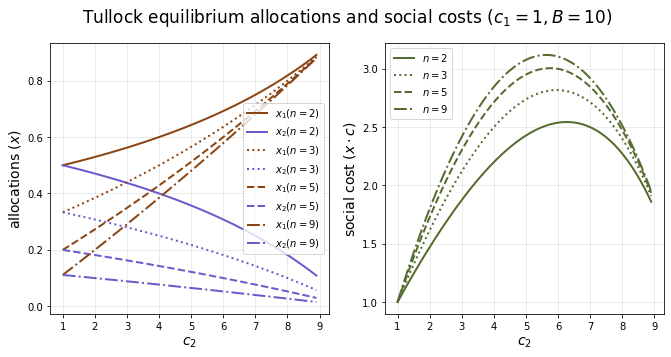

In [174]:
f, axarr = plt.subplots(ncols = 2, figsize=(11,5))

ls = ['-', ':', '--', '-.']
for i in range(4):
    axarr[0].plot(c2s, allos[i,:,0], label=r'$x_1 (n={})$'.format(ns[i]+1),
                  linestyle=ls[i], color='saddlebrown', linewidth=2)

    axarr[0].plot(c2s, allos[i,:,1], label=r'$x_2 (n={})$'.format(ns[i]+1),
                  linestyle=ls[i], color='slateblue', linewidth=2)

    axarr[1].plot(c2s, scs[i,:], label=r'$n={}$'.format(ns[i]+1),
                  linestyle=ls[i], color='darkolivegreen', linewidth=2)

for ax in axarr:
    ax.set_xlabel(r'$c_2$', size=14)
    ax.grid(alpha=0.3)

    ax.legend()
axarr[0].set_ylabel(r'allocations ($x$)', size=14)
axarr[1].set_ylabel(r'social cost ($x \cdot c$)', size=14)

f.suptitle(r'Tullock equilibrium allocations and social costs ($c_1=1, B=10$)', size=17)
plt.savefig('out.png', facecolor='white', dpi=200, bbox_inches='tight')
plt.show()